In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

<h1><center> Grenoble INP - École Nationale Supérieur de l’Énergie, l’Eau et l’Environnement</center></h1>

![GrenobleINP Logo](https://upload.wikimedia.org/wikipedia/fr/c/c6/Grenoble_INP_-_Ense3_%28logo%29.svg)

<h2><center>Smart Cities</center></h2> 
<center><i style="font-size:20px;">Dynamic Models for Building Energy Management</i></center>

![thermal](img/thermal.png)

<h3>Guided by: Christian GHIAUS & Majid BASEER</h3>
<h3>Written by:</h3>

* Ahmad Opeyemi ZUBAIR
* Tiwalade OYEBODE
* Solomon Berihu ARAYA

<h3><center>June 14, 2022</center></h3> 

<h3><center>Table of Contents</center></h3>

1. [INTRODUCTION](#INTRODUCTION)
2. [BUILDING PLAN](#BUILDING-PLAN)
3. [HYPOTHESES](#HYPOTHESES)
4. [THERMAL MODEL](#THERMAL-MODEL)
5. [MATHEMATICAL MODEL](#MATHEMATICAL-MODEL)
6. [MODEL IMPLEMENTATION](#MODEL-IMPLEMENTATION)
7. [STEADY-STATE RESULTS](#STEADY-STATE-RESULTS)
8. [DYNAMIC SIMULATION](#DYNAMIC-SIMULATION)
9. [CONCLUSION](#CONCLUSION)

##### INTRODUCTION
Heat consumption management and effective temperature control strategies to meet heat demand in residential and office buildings have become an important aspect within energy management. A thermal dynamic model of a building is not only necessary to estimate the energy consumption under different operating conditions but also to design effective controllers.  

This project investigates the thermal performance of a typical studio apartment with an area of 26.88 m<sup>2</sup> as shown in the figure below. It consists of a bedroom, a kitchen, an HVAC system, an enclosed bathroom with the shower & toilet, and the living space. The building height is a standard 10 feet i.e. 3.05 m.  

![floor](img/floor_plan.png)

In addition, there are three equal-sized windows, an entrance door and the bathroom door. It is assumed that the southern and eastern walls of the apartment adjoin that of another studio. Therefore, only the western and northern walls are considered during modelling.

The composition of the different sub-components of the building are as detailed below:  

* **External Walls**: the external walls are made of 200 mm concrete blocks with an 80 mm layer of drywall backed with fiberglass insulation on the interior. A schematic of the external wall is presented in the figure below. 
![ext_wall](img/wall.png)  

* **Bathroom Walls**: the bathroom walls and door are made of frameless tempered glass panels which is 9.5 mm thick.

* **Entrance Door**: the entrance door is made of plywood which is 30 mm thick.

* **Windows**: the windows are made of float glass which is 4 mm thick with dimensions (0.96 × 0.96).

The dimension and surface areas of the building are:

In [2]:
Sc = Si = 27.43     # m² surface of the concrete and insulation
Sg = 2.76           # m² surface of the glass window
Sw = 2.14           # m² surface of the wooden door
St =  12.81          # m² surface of the tempered glass shower enclosure

The building is ventilated; the volumetric air flow rate is `Va_dot`: 

In [3]:
Va = 69.54          # m³ volume of air
ACH = 1             # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration

The thermophysical propoerties of air:

In [4]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K
air

{'Density': 1.2, 'Specific heat': 1000}

The thermophysical propoerties of the materials and surface areas of the materials in the wall:

In [5]:
wall = {'Conductivity': [1.4, 0.027, 1.4, 0.13, 1.1],  # W/m.K
        'Density': [2300, 55, 2500, 650, 2520],        # kg/m³
        'Specific heat': [880, 1210, 750, 1800, 720],  # J/kg.K
        'Width': [0.2, 0.08, 0.004, 0.030, 0.0095],
        'Surface': [Sc, Si, Sg, Sw, St],  # m²
        'Slices': [4, 2, 1, 2, 1]}                # number of discretizations
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass', 'Wood', 'Tempered Glass'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete,1.400,2300,880,0.2000,27.43,4
Insulation,0.027,55,1210,0.0800,27.43,2
Glass,1.400,2500,750,0.0040,2.76,1
Wood,0.130,650,1800,0.0300,2.14,2
Tempered Glass,1.100,2520,720,0.0095,12.81,1


The radiative properties of the surfaces are:

In [6]:
ε_wLW = 0.9     # long wave wall emmisivity (concrete)
α_wSW = 0.2     # absortivity white surface
ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83    # short wave glass transmitance (glass)
α_gSW = 0.1     # short wave glass absortivity

ε_woW = 0.88     # long wave wall emmisivity (wood)
α_woSW = 0.7     # absortivity brown surface (wood)

σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant

**Controller Gain**  
The controller gain of the HVAC system is set at 2 discrete values as follow:

In [7]:
# P-controler gain
#Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0

##### HYPOTHESES
The following assumptions were made when constructing the thermal model of the apartment:
* It is assumed that the southern and eastern walls of the apartment adjoin that of another studio. Therefore, only the western and northern walls are considered during modelling.
* Since the wallpaper is very thin (0.5 mm), it is neglected in the thermal model.
* Uniform surface temperature on each wall.
* Heat transfer is unidirectional in each wall.
* The LW radiation exchange between outer surfaces and the ground is neglected.
* Heat transfers with the floor and the ceiling are neglected.
* Thermal resistances due to various heat transfer phenomena are lumped together for the window and doors to simplify the model.
* The temperature set by the HVAC controller only affects the air in the the living space.
* Heat transfer from the exposed kitchen ovens to the indoor air.

##### THERMAL MODEL
To construct the thermal model of the building, 6 heat transfer pathways are considered as shown in the figure below.
![flows](img/heat_flows.png)

The corresponding thermal model of the building is depicted in the figure below.

![model](img/model.png)

Some variables in the model are explained as follows:

* $R_6$: thermal resistance of the concrete in series with the insulation
* $R_9$: lumped thermal resistance due to convection and conduction
* $T_o$: outside temperature 
* $T_{i,sp}$: indoor temperature set point
* $\dot{Q}_{aux}$: auxillary heat flow from the kitchen ovens 
* $\phi_t$: absorbed radiative heat flow rate of the tempered glass walls
* $\phi_i$: indoor radiative heat flow rate
* $\phi_o$: outdoor radiative heat flow rate
* $C_2$: heat capacity of the indoor air
* $C_5$: heat capacity of the concrete 
* $C_6$: heat capacity of the insulation


Convection coeficients:

In [8]:
# convection coefficients, W/m² K
h = pd.DataFrame([{'in': 4., 'out': 10}])

##### MATHEMATICAL MODEL

The thermal model of the apartment has 7 nodes, 11 thermal resistances, and 6 thermal pathways and 11 flow branches. Using these, we can construct the required matrices. 

* **Incidence Matrix (A)**: the incidence matrix shows how the temperature nodes are connected by branches of heat flow. It consists of $n_q$ rows and $n_θ$ columns, where $n_q$ is the number of flow branches and $n_θ$ is the number of temperature nodes. Therefore, our A matrix has a dimension of 11 × 7 and is obtained as follows.
\begin{align*}
    &e_1 = T_o - \theta_2  \hspace{1cm} e_2 = T_{i,sp} - \theta_2 \hspace{1cm} 
    e_3 = T_o - \theta_2  \hspace{1cm} e_4 = T_o - \theta_4 \\
    &e_5 = \theta_4 - \theta_5 \hspace{1cm} e_6 = \theta_5 - \theta_6 \hspace{1cm} e_7 = \theta_6 - \theta_7 \hspace{1cm} e_8 = \theta_7 - \theta_2 \\
    &e_9 = \theta_2 - \theta_3 \hspace{1cm} e_{10} = \theta_3 - \theta_1 \hspace{1cm} e_{11} = \theta_2 - \theta_1
\end{align*}

Using the equation $e = -A\theta + b$, we construct the incidence matrix as follows:
\begin{equation*}
    \begin{bmatrix}
        e_1 \\ e_2 \\ e_3 \\ e_4 \\ e_5 \\ e_6 \\ e_7 \\ e_8 \\ e_9 \\ e_{10} \\ e_{11} 
    \end{bmatrix} = -
    \overbrace{
        \begin{bmatrix}
        0 & 1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & -1 & 1 & 0 & 0 \\
        0 & 0 & 0 & 0 & -1 & 1 & 0 \\
        0 & 0 & 0 & 0 & 0 & -1 & 1 \\
        0 & 1 & 0 & 0 & 0 & 0 & -1 \\
        0 & -1 & 1 & 0 & 0 & 0 & 0 \\
        1 & 0 & -1 & 0 & 0 & 0 & 0 \\
        1 & -1 & 0 & 0 & 0 & 0 & 0 \\
    \end{bmatrix}
    }^{A}
    \begin{bmatrix}
        \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \\ \theta_5 \\ \theta_6 \\ \theta_7 
    \end{bmatrix} + 
    \begin{bmatrix}
        T_o \\ T_{i,sp} \\ T_o \\ T_o \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0
    \end{bmatrix}
\end{equation*}  

* **Conductance Matrix (G)**: the conductance matrix is a diagonal matrix containing the conductances. Its size is $n_q$ × $n_q$ where $n_q$ is the number of flow branches. Therefore our G matrix is 11 × 11 and is obtained as follows.
\begin{align*}
    &q_1 = G_1e_1  \hspace{1cm} q_2 = G_2e_2 \hspace{1cm} 
    q_3 = G_3e_3  \hspace{1cm} q_4 = G_4e_4 \\
    &q_5 = G_5e_5 \hspace{1cm} q_6 = G_6e_6 \hspace{1cm} q_7 = G_7e_7 \hspace{1cm} q_8 = G_8e_8 \\
    &q_9 = G_9e_9 \hspace{1cm} q_{10} = G_{10}e_{10} \hspace{1cm} q_{11} = G_{11}e_{11}
\end{align*}
Using the equation q = Ge, we construct the conductance matrix as follows:
\begin{equation*}
    \begin{bmatrix}
        q_1 \\ q_2 \\ q_3 \\ q_4 \\ q_5 \\ q_6 \\ q_7 \\ q_8 \\ q_9 \\ q_{10} \\ q_{11} 
    \end{bmatrix} =
    \overbrace{
        \begin{bmatrix}
        G_1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & G_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & G_3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & G_4 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & G_5 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & G_6 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & G_7 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & G_8 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & G_9 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & G_{10} & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & G_{11} \\
    \end{bmatrix}
    }^{G}
    \begin{bmatrix}
        e_1 \\ e_2 \\ e_3 \\ e_4 \\ e_5 \\ e_6 \\ e_7 \\ e_8 \\ e_9 \\ e_{10} \\ e_{11}
    \end{bmatrix}
\end{equation*}  

* **Capacity Matrix (C)**: The capacity matrix is the diagonal matrix containing the capacities. If there is no capacity in the node n, then $C_{n,n} = 0$. Its size is $n_\theta$ × $n_\theta$ where $n_\theta$ is the number of temperature nodes. Therefore our C matrix is 7 × 7 and is obtained as follows:
\begin{align*}
    &0 = q_{10} + q_{11}  \hspace{1cm} C_2\dot{\theta}_2 = q_1 + q_2 + q_3 + q_8 - q_9 - q_{11} + \dot{Q}_{aux} \hspace{1cm} C_3\dot{\theta}_3 = q_9 - q_{10} + \phi_t \\
    &0 = q_4 - q_5 + \phi_o \hspace{1cm} C_5\dot{\theta}_5 = q_5 - q_6 \hspace{1cm} C_6\dot{\theta}_6 = q_6 - q_7 \hspace{1cm} 0 = q_7 - q_8 + \phi_i 
\end{align*}

Using the equation $C\dot{\theta} = A^Tq + f$, we construct the capacitance matrix as follows:
\begin{equation*}
    \overbrace{
        \begin{bmatrix}
        0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & C_2 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & C_3 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & C_5 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & C_6 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        \end{bmatrix}
    }^{C} \begin{bmatrix}
        \theta_1 \\ \dot{\theta}_2 \\ \dot{\theta}_3 \\ \theta_4 \\ \dot{\theta}_5 \\ \dot{\theta}_6 \\ \theta_7 
    \end{bmatrix}  = 
    \begin{bmatrix}
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
        1 & 1 & 1 & 0 & 0 & 0 & 0 & 1 & -1 & 0 & -1 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -1 & 0 \\
        0 & 0 & 0 & 1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 1 & -1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 1 & -1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & -1 & 0 & 0 & 0 \\
    \end{bmatrix}
    \begin{bmatrix}
        q_1 \\ q_2 \\ q_3 \\ q_4 \\ q_5 \\ q_6 \\ q_7 \\ q_8 \\ q_9 \\ q_{10} \\ q_{11} 
    \end{bmatrix} + 
    \begin{bmatrix}
        0 \\ \dot{Q}_{aux} \\ \phi_t \\ \phi_o  \\ 0 \\ 0 \\ \phi_i
    \end{bmatrix}
\end{equation*}

##### MODEL IMPLEMENTATION
The Python implementation of each matrix in the model is described as follows:

**Incidence matrix**

In [9]:
A = np.zeros([11, 7])
A[0, 1] = 1
A[1, 1] = 1
A[2, 1] = 1
A[3, 3] = 1
A[4, 3], A[4, 4] = -1, 1
A[5, 4], A[5, 5] = -1, 1
A[6, 5], A[6, 6] = -1, 1
A[7, 1], A[7, 6] = 1, -1
A[8, 1], A[8, 2] = -1, 1
A[9, 0], A[9, 2] = 1, -1
A[10, 0], A[10, 1] = 1, -1
np.set_printoptions(suppress=False, threshold=np.inf)
print(A)

[[ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.]
 [ 0.  1.  0.  0.  0.  0. -1.]
 [ 0. -1.  1.  0.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.  0.]]


**Conductance matrix**

The heat transfer phenomena of the model are implemented as follows:

In [10]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']

# Convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass
Gwo = h * wall['Surface'][3]    # wood
Gt = h * wall['Surface'][4]     # tempered glass

# Long-wave radiation exchnage
# GLW1 = ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation'] * 4 * σ * Tm**3
# GLW2 = Fwg * wall['Surface']['Insulation'] * 4 * σ * Tm**3
# GLW3 = ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass'] * 4 * σ * Tm**3
# long-wave exg. wall-glass
# GLW = 1 / (1 / GLW1 + 1 / GLW2 + 1 / GLW3)

# ventilation & advection
Gv = Va_dot * air['Density'] * air['Specific heat']

# tempred glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gt['in'] + 1 / (2 * G_cd['Tempered Glass'])))

In [11]:
Gdoor = Gwo.iloc[0]['out'] + G_cd['Wood'] + Gwo.iloc[0]['in']
Gwindow = Gg.iloc[0]['out'] + G_cd['Glass'] + Gg.iloc[0]['in']

In [12]:
G = np.diag([Gdoor, Kp, Gwindow,
             Gw.iloc[0]['out'], G_cd['Concrete'],
             G_cd['Insulation'] + G_cd['Concrete'], G_cd['Insulation'], Gw.iloc[0]['in'], Ggs,
             2 * G_cd['Tempered Glass'], G_cd['Tempered Glass']])
np.set_printoptions(precision=3, threshold=np.inf, suppress=True)

**Capacity matrix**

The thermal capacities of the model are implemented as follows:

In [13]:
C_ = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C_['Air'] = air['Density'] * air['Specific heat'] * Va

In [14]:
C = np.zeros([7, 7])
C[1, 1] = C_['Air']
C[2, 2] = C_['Tempered Glass']
C[4, 4] = C_['Concrete']
C[5, 5] = C_['Insulation']

np.set_printoptions(suppress=False, threshold=np.inf)
print(C.shape)

(7, 7)


**Input vectors**

The vector of *temperature sources* is **b**. It has the size of the number of flow branches $n_q$ (in this case 11) and any element corresponding to a branch without a heat source is zero. We assume the temperature of the air outside the building ($T_o$) is 15 ◦C while the building's set temperature ($T_{isp})$ is 20 ◦C.

In [15]:
b = np.zeros(11)
b[[0, 2, 3]] = 15
b[[1]] = 20

print(b)

[15. 20. 15. 15.  0.  0.  0.  0.  0.  0.  0.]


The vector of *heat sources* is **f**. It has the size of the number of temperature nodes $n_θ$ (in this case 7). We assign some arbitrary non-zero values to the heat sources as follows:

In [16]:
f = np.zeros(7)
f[[1, 2, 3, 6]] = 1000 + np.array([6000, 4000, 0, 4000])

f

array([   0., 7000., 5000., 1000.,    0.,    0., 5000.])

The inputs vector **u** is:

$$\mathbf{u} = \begin{bmatrix}
\mathbf{b}\\ 
\mathbf{f}
\end{bmatrix}$$

where **b** is  the vector of temperature sources and **f** the vector of heat flow sources. Note that in Python, a vector is a row. The **u** vector is obtained as an horizontal stack of the sources that are in the circuit (non-zero elements of **b** and **f**):

In [17]:
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])
u

array([  15.,   20.,   15.,   15., 7000., 5000., 1000., 5000.])

**Output vector**  
The vector of outputs is **y**. It has the size of the number of temperature nodes $n_θ$ (in this case 7). The non-zero values of **y** indicate the nodes that are the outputs of the model. Let's assume that all temperatures are of interest:

In [18]:
y = np.ones(7)

##### STEADY-STATE RESULTS

For steady state analysis of the apartment, our goal is to determine the temperature at all the nodes given the available input of known temperatures and heat sources. Then we compare the results of the thermal circuit and its state-space representation.  
The thermal cirucuit and its state space representation are given by the following equations:
$$y_{tc} = (A^T G A)^{-1}(A^T G b + f)$$
$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$ 

Let's compare the steady state results obtained with the differential-algebraic equations of the thermal circuit.

In [19]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

In [20]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

[34.07  30.863 35.674 20.254 22.553 24.745 72.411]
[34.07  30.863 35.674 20.254 22.553 24.745 72.411]
Max error in steady-state between thermal circuit and state-space: 1.42e-14


It can be observed that both the thermal circuit and the state space representation give us the same results for all temperature nodes. Using the current model, it can be seen that the temperaure of the insulation reaches a high degree. This is due to the high heat flow from the kitchen oven which heats up the indoor air. This heat is mostly retained by the insulation due to its high specific heat capacity which results in its high temperature.

Furthermore, the maximum error in steady-state between the two is given as 1.42 × 10$^{-14}$. This shows that the matrices are properly constructed for the given model.  

##### DYNAMIC SIMULATION

In dynamic simulation, the inputs vary in time. We indicate the sources in the circuit by ones:

In [21]:
b = np.zeros(11)
b[[0, 1, 2, 3]] = 1

f = np.zeros(7)
f[[1, 2, 3, 6]] = 1

In addition, we consider that the output of the circuit is the indoor temperature (i.e. the temperature of node 2):

In [22]:
y = np.zeros(7)
y[[1]] = 1

The state-space representation is obtained from the differential-algebraic equations of the thermal circuit:

In [23]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

**Time Step**  
The maximum time step for numerical stability of Euler explicit itegration in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$:

$$ \Delta t \leq \min (-2 / \lambda_i) = \min T_i/2$$

where $T_i$ is the time constants, $T_i = - \frac{1}{\lambda_i} $

In [24]:
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 72.40 s


We need to chose a time step smaller than `dtmax`:

In [25]:
dt = 60

**Step Response**

Next, we obtain the dynamic response of the system to a step input. The duration of the simulation is set to 4 hrs.

In [26]:
duration = 3600 * 4
n = int(np.floor(duration / dt))
t = np.arange(0, n * dt, dt)    # time vector

For the input vector **u**, the outdoor temperatures will be `To = 1`, the indoor set-point temperature will `Tsp =0`, and the heat flow sources will be zero. 

In [27]:
# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To Tsp Phii Phio Qaux Phia]
u = np.zeros([8, n])
u[0:3, :] = np.ones([3, n])

The vectors for the evolution of **tem**peratures (states) in time for Euler **exp**licit and **imp**licit are:

In [28]:
temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

The output of the dynamic simulation is as shown below:

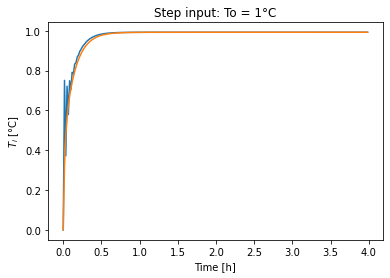

In [29]:
y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')
plt.show()

In [30]:
b = np.zeros(11)
b[[0, 2, 3]] = 1
f = np.zeros(7)

ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[6]:.4f} °C')
print(f'- response to step input:{float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 1.0000 °C
- response to step input:0.9923 °C


As observed, the dynamic model settles close to the reference value of 1 °C in about an hour. This shows that the model operates well and has rapid execution time.  

**Simulation with weather data**

We also simulate the response of the dynamic model using real weather data from Lyon. 

In [31]:
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00' 
end_date = '2000-02-05 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

From the weather data, we calculate the hourly solar radiation on a tilted surface, `Φt1` [W]:

In [32]:
surface_orientation = {'slope': 60,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

The weather data is at the time-step of 1h. We adjusst it to be at time step of `dt`. 

In [33]:
data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

We also consider the indoor temperature setpoint $T_{i,sp}$ and auxiliary heat flow $\dot{Q}_{aux}$ constant for the whole simulation period.

In [34]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

The simulation time vector, at time step `dt`is:

In [35]:
t = dt * np.arange(data.shape[0])

The input vector is formed by the temperature sources $\left [ T_o, T_{i,sp}, T_o ,T_o,  \right ]$ and the heat flow sources $\left [ \dot{Q}_{aux}, \Phi_t, \Phi_o, \Phi_i \right ]$

In [36]:
u = pd.concat([data['To'], data['Ti'], data['To'], data['To'], data['Qa'],
               α_gSW * wall['Surface']['Tempered Glass'] * data['Φt1'],
               α_wSW * wall['Surface']['Concrete'] * data['Φt1'], 
               τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φt1']
               ],
               axis=1)

The initial value of the state-vector is set to a non-zero value:

In [37]:
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

Explicit Euler integration in time
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$

In [38]:
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):
$$y = C_s \theta + D_s u$$
and the variation of the heat flow of the HVAC system:
$$q_{HVAC} = K_p (T_{i,sp} - y)$$
where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

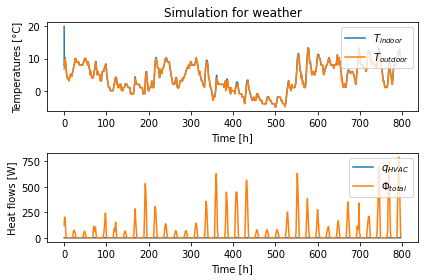

In [39]:
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

As observed from the plots above, when the gain of the HVAC system is set to a very low value of 1 × 10$^{-3}$, the system behaves as if there is no controller and no additional heat is produced by the HVAC system. Therefore, the only remaining influence on the indoor air is the outdoor air and thus the temperature of the indoor air closely follows the evolution of that out of the outer air. 

When a high gain is set for the controller (1 × 10$^{4}$), the HVAC system behaves like a perfect controller and aims to keep the indoor temperature at its constant set point of 20 °C irrespective of the outdoor temperature and this is evident in the plot. Therefore, the heat produced by the HVAC increases or decreases depending on the situation to keep this constant temperature.   

##### CONCLUSION

In this project, we have successfully developed and implemented a thermal model for observing the heat flows in a typical studio apartment. The objective is to analyze the evolution of the temperature in the apartment at different nodes. The model was simulated in both steady and dynamic states. For steady state analysis, the results show that the model performs excellently and virtually no error is recorded when compared to a state-space representation. However, the temperature in certain nodes can reach a fairly high degree.  

For the dynamic simulation, the model was simulated with no controller and with a perfect controller using weather data obtained online. With no controller, no power is produced by the HVAC system and the indoor temperature evolves similarly to the outdoor temperature. With a perfect controller, the HVAC system aims to keep the indoor temperature at a constant temperature of 20 °C irrespective of the outdoor temperature. However, the model still shows some slight fluctuations in achieving this goal which shows its not perfect yet.  